# Training of the efficiency model
##### Notebook tested within the environment `TensorFlow on GPU` available in the docker image [`landerlini/lhcbaf:v0p8`](https://hub.docker.com/r/landerlini/lhcbaf)

This notebook is part of a pipeline, in particular it requires the data preprocessed as defined in the notebook [Preprocessing.ipynb](./Preprocessing.ipynb) and the validation of the trained model is demanded to the notebook [Efficiency-validation.ipynb](./Efficiency-validation.ipynb).

Here, we define the training procedure for the Deep Neural Network model defining the class each track is reconstructed as.
As evident from the preprocessing step, we restrain the classes to:
 * long tracks (traversing the whole detector)
 * upstream tracks (traversing the VELO and the Tracker Turincensis)
 * downstream tracks (traversing the Tracker Turicensis and the downstream tracker, TT).
 
We include as a class the "unreconstructed" category which includes both the non-reconstructed particles and those reconstructed as other classes.
 
The neural network we will train is designed to predict the probability each track is reconstructed as a given track.
In the deployment of the model we will assign the particle to a single class, by drawing one of the classes above based on the probabilities obtained from the network.

The classes are mutually exclusive, each particle can be assigned to at most one of the reconstruction classes.
Hence, we describe the problem as a multiclass classification with a multinomial probability function and a Categorical Cross-entropy as loss function.

## Libraries and environment setup

As for the [training of the acceptance model](./Acceptance.ipynb), we are using here the standard software stack for TensorFlow on GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

We ensure the GPU is properly loaded and assigned to TensorFlow as hardware accelerator for the training.

If the GPU is loaded properly, the following code block should result in a string similar to `'/devince:GPU:0'`.

In [2]:
tf.test.gpu_device_name()

''

## Loading data 

We are reading the data using our custom implementation of `FeatherReader` streaming the data directly to TensorFlow.
In particular, we are loading:
 * the training dataset to optimize the weights;
 * the validation dataset to evaluate possible overtraining and select model and tune the regularization hyper-parameters and techniques.

In [3]:
from feather_io import FeatherReader

reader_train =  FeatherReader(environ.get("TRAIN_DATA", "efficiency-train"), max_files=4)
ds_train = reader_train.as_tf_dataset()

reader_val =  FeatherReader(environ.get("VALIDATION_DATA", "efficiency-validation"), max_files=1)
ds_val = reader_val.as_tf_dataset()

We also load to RAM a small chunk of data to ease the model building.

In [4]:
X, y = next(iter(ds_train.batch(1_000_000)))
X.shape, y.shape

(TensorShape([1000000, 12]), TensorShape([1000000, 4]))

## Model definition

We define the neural network as a deep network with skip connections to limit the gradient vanishing problem.

Note that the activation of the last layer is a [softmax](https://keras.io/api/layers/activations/#softmax-function) as expected by the [Categorical Cross-entropy loss function](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class).

Unfortunately, the `scikinC` package that we are relying on to deploy these models in Lamarr does not support the `softmax` activation function is indicated as a string, but needs it defined as an independent layer.

In [5]:
from pidgan.players.classifiers import ResMultiClassifier

model = ResMultiClassifier(
    num_multiclasses=y.shape[1],
    num_hidden_layers=10,
    mlp_hidden_units=128,
    mlp_hidden_activation="relu",
    mlp_hidden_kernel_regularizer=tf.keras.regularizers.L2(5e-4),
    mlp_dropout_rates=0.0,
    name="classifier",
)

In [6]:
model(X[:256])
model.summary()

Model: "classifier_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  1664      ['input_1[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dropout_0[0][0]']           
                                                                                    

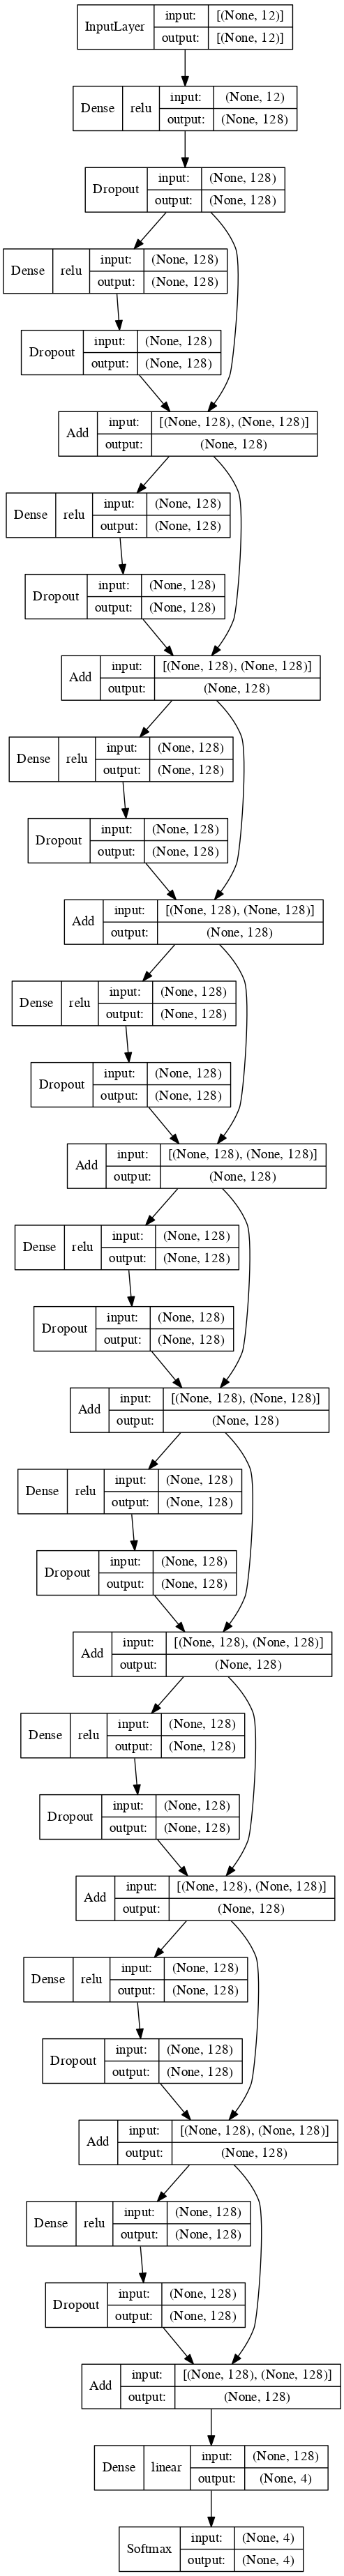

In [7]:
tf.keras.utils.plot_model(
    model.export_model,
    to_file="./images/efficiency-model.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

The configuration of the training is standard for the multiclass classification task.

 * [`CategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function
 * [`RMSprop`](https://keras.io/api/optimizers/rmsprop/) optimizer

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

Once again we split the training procedure in two steps, we train with a very high learning rate as long as it brings to some improvement in the value of the loss function. Then we drastically reduce it to a much smaller value.

Note that to limit the local minima in the loss function and ease convergence towards the global minimum at such a high learning rate, we apply a small [smoothing of the labels](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06). 
This results into a non-probabilistic meaning of the generated output, which is unaccepable to our purpose.
Hence, we reset the label smoothing to zero for the second (and last) part of the training with a reduced learning rate.



In [9]:
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.F1Score(name="f1")],
    optimizer=Adam(1e-2),
)

In [10]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

lr_sched = LearnRateExpDecay(
    model.optimizer,
    decay_rate=0.1,
    decay_steps=35_000,
    verbose=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1",
    min_delta=1e-5,
    patience=5,
    mode="max"
)

In [11]:
batch_size = 25_000
num_epochs = 300

data_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

callbacks = [lr_sched]

train = model.fit(data_train, epochs=num_epochs, validation_data=data_val, callbacks=callbacks)

Epoch 1/300
208/208 [==============================] - 29s 126ms/step - loss: 1.6544 - auc: 0.9257 - f1: 0.4206 - lr: 0.0099 - val_loss: 1.0209 - val_auc: 0.9607 - val_f1: 0.4749
Epoch 2/300
208/208 [==============================] - 26s 120ms/step - loss: 0.9321 - auc: 0.9623 - f1: 0.5248 - lr: 0.0098 - val_loss: 0.8570 - val_auc: 0.9644 - val_f1: 0.5482
Epoch 3/300
208/208 [==============================] - 26s 123ms/step - loss: 0.8074 - auc: 0.9647 - f1: 0.5831 - lr: 0.0097 - val_loss: 0.7611 - val_auc: 0.9660 - val_f1: 0.5955
Epoch 4/300
208/208 [==============================] - 26s 120ms/step - loss: 0.7318 - auc: 0.9659 - f1: 0.6074 - lr: 0.0095 - val_loss: 0.7016 - val_auc: 0.9669 - val_f1: 0.6088
Epoch 5/300
208/208 [==============================] - 26s 123ms/step - loss: 0.6831 - auc: 0.9666 - f1: 0.6198 - lr: 0.0094 - val_loss: 0.6625 - val_auc: 0.9674 - val_f1: 0.6263
Epoch 6/300
208/208 [==============================] - 26s 121ms/step - loss: 0.6507 - auc: 0.9670 - f1: 

In [12]:
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.0),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.F1Score(name="f1")],
    optimizer=Adam(model.optimizer.learning_rate),
)

In [13]:
num_epochs_ft = 200

lr_sched = LearnRateExpDecay(
    model.optimizer,
    decay_rate=0.1,
    decay_steps=50_000,
    verbose=True,
)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-5,
#     patience=5,
#     mode="min"
# )

callbacks = [lr_sched]  # [lr_sched, early_stop]

train_ft = model.fit(data_train, epochs=num_epochs_ft, validation_data=data_val, callbacks=callbacks)

Epoch 1/200
     86/Unknown - 13s 118ms/step - loss: 0.4136 - auc: 0.9714 - f1: 0.6735 - lr: 1.6455e-04

208/208 [==============================] - 29s 124ms/step - loss: 0.4115 - auc: 0.9715 - f1: 0.6747 - lr: 1.6408e-04 - val_loss: 0.4070 - val_auc: 0.9719 - val_f1: 0.6838
Epoch 2/200
208/208 [==============================] - 26s 120ms/step - loss: 0.4091 - auc: 0.9716 - f1: 0.6759 - lr: 1.6251e-04 - val_loss: 0.4064 - val_auc: 0.9719 - val_f1: 0.6829
Epoch 3/200
208/208 [==============================] - 26s 121ms/step - loss: 0.4086 - auc: 0.9716 - f1: 0.6764 - lr: 1.6096e-04 - val_loss: 0.4061 - val_auc: 0.9719 - val_f1: 0.6830
Epoch 4/200
208/208 [==============================] - 26s 122ms/step - loss: 0.4084 - auc: 0.9717 - f1: 0.6768 - lr: 1.5943e-04 - val_loss: 0.4060 - val_auc: 0.9720 - val_f1: 0.6842
Epoch 5/200
208/208 [==============================] - 26s 121ms/step - loss: 0.4082 - auc: 0.9717 - f1: 0.6770 - lr: 1.5791e-04 - val_loss: 0.4058 - val_auc: 0.9720 - val_f1: 0.6840
Epoch 6/200
208/208 [==============================] - 26s 121ms/step - loss: 0.4081 - auc: 0.971

The two training phases are well visible in the plot below reporting the full history of the training procedure.

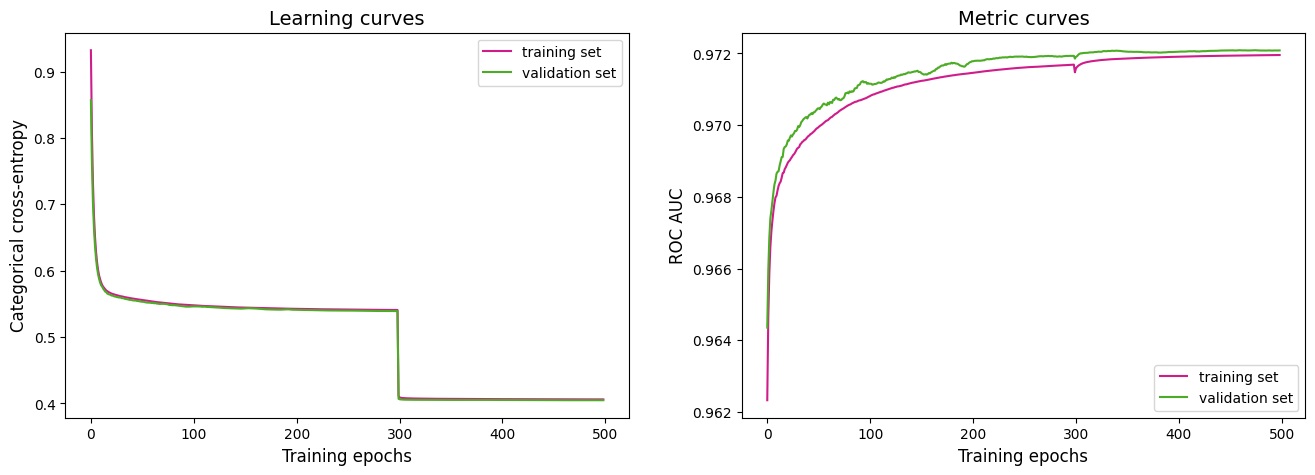

In [14]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Categorical cross-entropy", fontsize=12)
plt.plot(train.history["loss"][1:] + train_ft.history["loss"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_loss"][1:] + train_ft.history["val_loss"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)
plt.plot(train.history["auc"][1:] + train_ft.history["auc"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_auc"][1:] + train_ft.history["val_auc"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

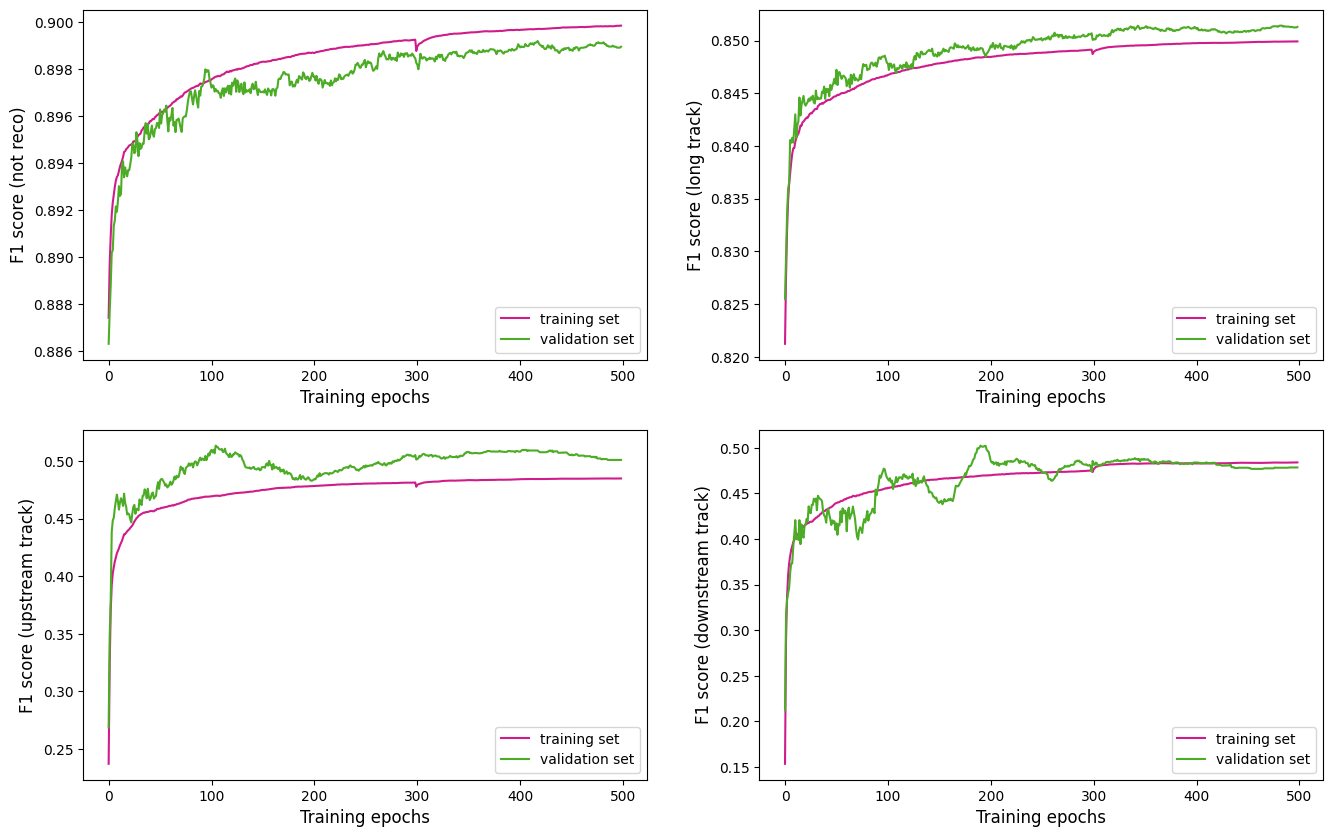

In [15]:
plt.figure(figsize=(16, 10), dpi=100)

for i, track in enumerate(["not reco", "long track", "upstream track", "downstream track"]):
    plt.subplot(2, 2, i+1)
    plt.xlabel("Training epochs", fontsize=12)
    plt.ylabel(f"F1 score ({track})", fontsize=12)
    plt.plot(np.array(train.history["f1"][1:] + train_ft.history["f1"])[:, i], lw=1.5, color="#d01c8b", label="training set")
    plt.plot(np.array(train.history["val_f1"][1:] + train_ft.history["val_f1"])[:, i], lw=1.5, color="#4dac26", label="validation set")
    plt.legend(loc="lower right", fontsize=10)

plt.show()

In [16]:
train_history = train.history.copy()
for i, track in enumerate(["not_reco", "long_trk", "upstream_trk", "downstream_trk"]):
    train_history[f"f1_{track}"] = np.array(train_history["f1"])[:, i]
    train_history[f"val_f1_{track}"] = np.array(train_history["val_f1"])[:, i]
train_history.pop("f1")
train_history.pop("val_f1")
pd.DataFrame(train_history).to_csv("./exports/efficiency-train.csv")

train_history_ft = train_ft.history.copy()
for i, track in enumerate(["not_reco", "long_trk", "upstream_trk", "downstream_trk"]):
    train_history_ft[f"f1_{track}"] = np.array(train_history_ft["f1"])[:, i]
    train_history_ft[f"val_f1_{track}"] = np.array(train_history_ft["val_f1"])[:, i]
train_history_ft.pop("f1")
train_history_ft.pop("val_f1")
pd.DataFrame(train_history_ft).to_csv("./exports/efficiency-train-ft.csv")

## A first rough validation (sanity checks)

As done for the [acceptance training](./Acceptance.ipynb), we perform simple and quick checks on the trained model to ensure that the model makes sense, while demanding the most important part of the validation to a [dedicated notebook](./Efficiency-validation.ipynb).

First we plot the distribution of the original labels and of the predictions for the various categories. 

260/260 [==============================] - 14s 51ms/step
1.000000462358579


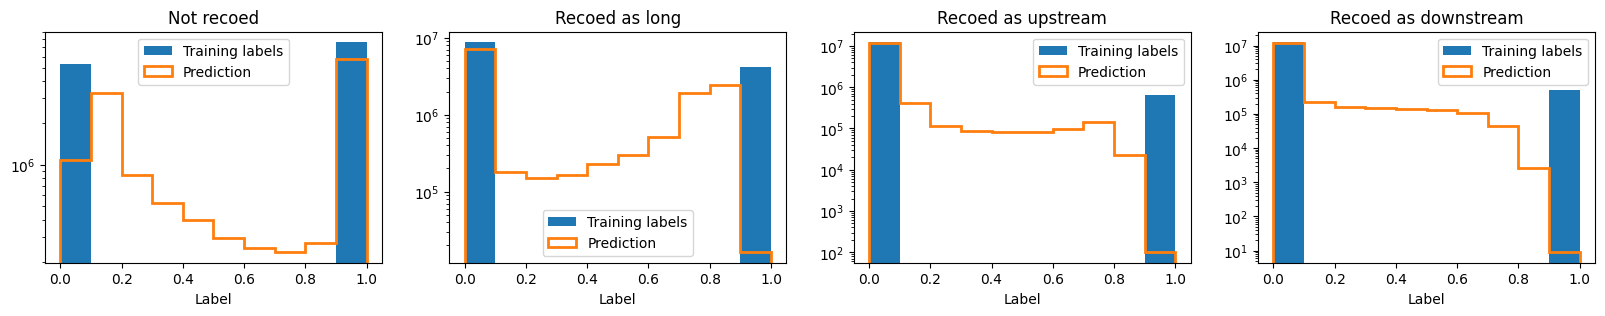

In [17]:
reader_test = FeatherReader(environ.get("TRAIN_DATA", "efficiency-test"), max_files=20)
head = reader_test.as_dask_dataframe().head(20_000_000, npartitions=-1)

X_test = head[reader_test.features].values
y_test = head[reader_test.labels].values
preds = model.predict(X_test, batch_size=50_000)

print(y_test.sum(axis=1).mean(axis=0))

n_classes = len(reader_test.labels)
plt.figure(figsize=(5 * n_classes, 3))

for iVar, varname in enumerate(reader_test.labels, 0):
    plt.subplot(1, n_classes, iVar+1)
    
    bins = np.linspace(0, 1, 11)
    plt.hist(y_test[:, iVar], bins=bins, label="Training labels")
    plt.hist(preds[:, iVar], bins=bins, histtype='step', linewidth=2, label="Prediction")
    plt.title(varname.replace("_", " ").capitalize())
    plt.xlabel("Label")
    plt.legend()
    plt.yscale('log')
plt.show()

Then we use the probability of belonging to the `long track` class as a weight to compare the distribution of candidates reconstructed as long tracks in the detailed simulation with candidates probably reconstructable as `long tracks` according to Lamarr.

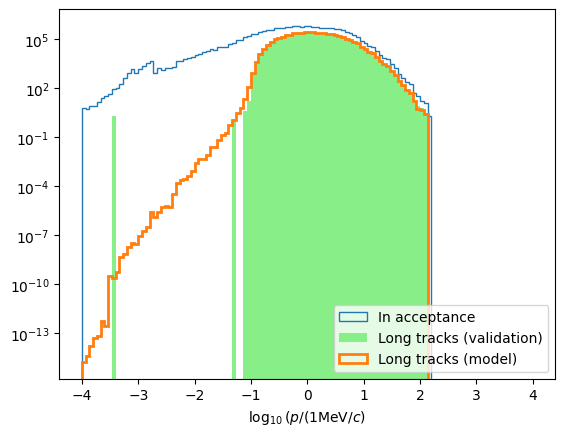

In [18]:
log_p = head['mc_log10_p']
mask_long = head['recoed_as_long'] == 1
w_long = preds[:, reader_test.labels.index('recoed_as_long')]

bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p[mask_long], bins=bins)
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=w_long)

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="In acceptance", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=true_numerator, label="Long tracks (validation)", color='#8e8')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="Long tracks (model)", histtype='step', linewidth=2)

plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend(loc="lower right")
plt.yscale("log")
plt.show()

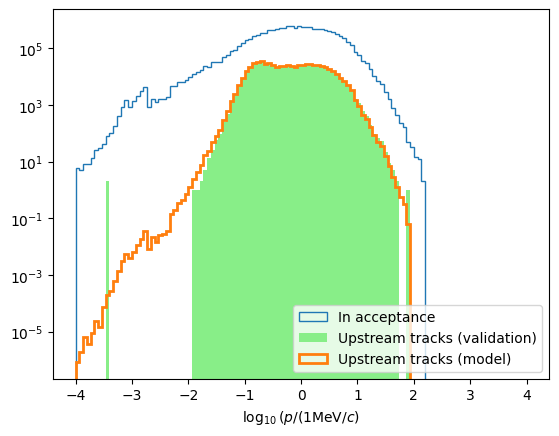

In [19]:
log_p = head['mc_log10_p']
mask_upstream = head['recoed_as_upstream'] == 1
w_upstream = preds[:, reader_test.labels.index('recoed_as_upstream')]

bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p[mask_upstream], bins=bins)
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=w_upstream)

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="In acceptance", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=true_numerator, label="Upstream tracks (validation)", color='#8e8')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="Upstream tracks (model)", histtype='step', linewidth=2)

plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend(loc="lower right")
plt.yscale("log")
plt.show()

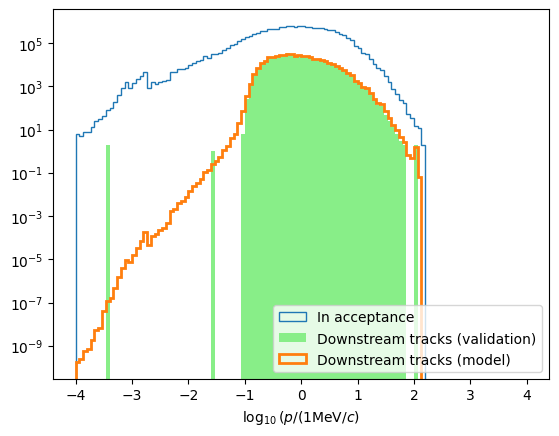

In [20]:
log_p = head['mc_log10_p']
mask_downstream = head['recoed_as_downstream'] == 1
w_downstream = preds[:, reader_test.labels.index('recoed_as_downstream')]

bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p[mask_downstream], bins=bins)
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=w_downstream)

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="In acceptance", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=true_numerator, label="Downstream tracks (validation)", color='#8e8')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="Downstream tracks (model)", histtype='step', linewidth=2)

plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend(loc="lower right")
plt.yscale("log")
plt.show()

In [21]:
import pickle

file_path = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/efficiency/tX.pkl"

with open(file_path, "rb") as file:
    X_scaler = pickle.load(file)

In [22]:
from pidgan.utils.preprocessing import invertColumnTransformer

for part in ["e", "mu", "h"]:
    query_index = reader_test.features.index(f"mc_is_{part}")
    query = X_test[:, query_index] == 1
    print(f"Shape for {part}:", X_test[query].shape, y_test[query].shape, preds[query].shape)
    
    X_query = invertColumnTransformer(X_scaler, X_test[query])

    np.savez_compressed(
        f"./exports/efficiency-results-{part}.npz",
        feat_vars=np.array(reader_test.features),
        label_vars=np.array(reader_test.labels),
        results=np.c_[X_query, y_test[query], preds[query]][:1_000_000],
    )

Shape for e: (2079858, 12) (2079858, 4) (2079858, 4)


Shape for mu: (159763, 12) (159763, 4) (159763, 4)
Shape for h: (10737324, 12) (10737324, 4) (10737324, 4)


# Exporting the model

As a last step, we export the model to the same directory where we stored the preprocessing steps.

In [23]:
import os
default_output_model = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/efficiency"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
model.export_model.save(output_model, save_format="tf")

INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/efficiency/assets


INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/efficiency/assets


# Conclusion

In this notebook we trained a model for the track reconstruction efficiency, implemented a very simple sanity check to ensure that the trained model makes sense, and finally we exported it to perform a more complete validation in a dedicated notebook.
